Importing libraries 

In [1]:
import numpy as np , pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb, lightgbm as lgbm, catboost as catb, imblearn as imb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import (f1_score, precision_score, classification_report,
                             recall_score, accuracy_score, confusion_matrix,
                             plot_confusion_matrix)
from scipy.stats import probplot

import warnings
warnings.simplefilter('ignore')

C:\Users\AHabe\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


EDA

In [2]:
df_train = pd.read_csv('course_project_train.csv')
df_test = pd.read_csv('course_project_test.csv')

print(f"Train:\t{df_train.shape[0]}\t sales and {df_train.shape[1]} features")
print(f'Test:\t{df_test.shape[0]}\t sales and {df_test.shape[1]} features')

Train:	7500	 sales and 17 features
Test:	2500	 sales and 16 features


In [3]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


Text(0.5, 1.0, 'Correlation with TARGET variable')

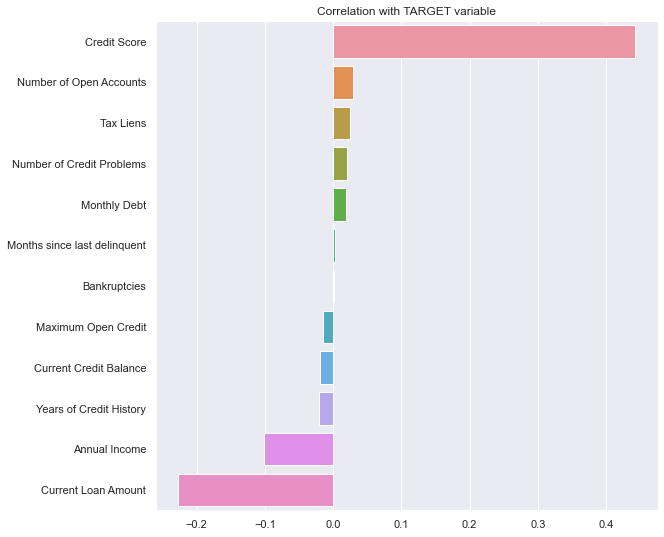

In [4]:
sns.set(font_scale=1)
corr_with_TARGET = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(9, 9))
sns.barplot(x=corr_with_TARGET.values, y=corr_with_TARGET.index)
plt.title('Correlation with TARGET variable')



In [5]:
for col in df_train.columns:
    pct_missing = np.mean(df_train[col].isna())
    if pct_missing:
        print('{} - {}%'.format(col, round(pct_missing*100)))



Annual Income - 21%
Years in current job - 5%
Months since last delinquent - 54%
Bankruptcies - 0%
Credit Score - 21%


Prepocessing

In [6]:
def fix_manual(df):
    
    mean_income = df['Annual Income'].mean()
    df['Annual Income'] = df['Annual Income'].fillna(mean_income)
    year_mode = df['Years in current job'].mode().astype(str)[0]
    df['Years in current job'] = df['Years in current job'].fillna(year_mode)
    df.loc[(df['Years in current job'] == '< 1 year') | (df['Years in current job'] == '1 year') |  (df['Years in current job'] == '2 years') | (df['Years in current job'] == '3 years') | (df['Years in current job'] == '4 years'),  'Years in current job'] = '4 or less years'
    df.loc[(df['Years in current job'] == '5 years') | (df['Years in current job'] == '6 years') | (df['Years in current job'] == '7 years'),  'Years in current job'] = '5-7 years'
    df.loc[(df['Years in current job'] == '8 years') | (df['Years in current job'] == '9 years') | (df['Years in current job'] == '10+ years'),  'Years in current job'] = '8 or more years'
    my_mean = df['Months since last delinquent'].mode()
    df['Months since last delinquent'] =  df['Months since last delinquent'].fillna(my_mean[0])
    df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
    df.loc[df['Current Loan Amount'] > (df['Annual Income'] * 100), 'Current Loan Amount'] = df['Annual Income'] * 50 * 0.7
    df.loc[df['Current Loan Amount'] > (df['Annual Income'] * 50), 'Current Loan Amount'] = df['Annual Income'] * 50 * 0.7
    mean_loan = df['Current Loan Amount'].mean()
    df.loc[df['Current Loan Amount'].isnull() == True,'Current Loan Amount'] = mean_loan
    df.loc[df['Current Credit Balance'] > (df['Annual Income'] * 30), 'Current Credit Balance'] = df['Annual Income'] * 30
    mean_df = df['Months since last delinquent'].mean()
    df['Months since last delinquent'] = df['Months since last delinquent'].fillna(mean_df)
    df.loc[df['Credit Score'] > 1000, 'Credit Score'] = 1000
    df_mean = df['Credit Score'].mean()
    df['Credit Score'] = df['Credit Score'].fillna(df_mean)
    df = df.drop('Number of Open Accounts', axis=1)
    df['month_income'] = df['Annual Income'] / 12
    df['Net Balance'] =  df['month_income'] - df['Monthly Debt']
    df.loc[(df['Current Credit Balance'] - df['Current Loan Amount'] ) < 0, 'Current Credit Balance'] = df['Current Loan Amount']
    df['how_much_used_credit_balance'] =   df['Current Credit Balance'] / df['Current Credit Balance'] * 100
    df.loc[df['Purpose'] == 'renewable energy', 'Purpose'] = 'business loan'
    df.loc[df['Purpose'] == 'small business', 'Purpose'] = 'business loan'
    df = pd.get_dummies(df, drop_first=True)
   
  
    return df




In [7]:
 def balance_data(X, y):
      #ros = SMOTE()
      #ros = ADASYN()
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X, y)
    return X_resampled, y_resampled

In [8]:
train_df = fix_manual(df_train)
test_df = fix_manual(df_test)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Annual Income                         7500 non-null   float64
 1   Tax Liens                             7500 non-null   float64
 2   Years of Credit History               7500 non-null   float64
 3   Maximum Open Credit                   7500 non-null   float64
 4   Number of Credit Problems             7500 non-null   float64
 5   Months since last delinquent          7500 non-null   float64
 6   Bankruptcies                          7500 non-null   float64
 7   Current Loan Amount                   7500 non-null   float64
 8   Current Credit Balance                7500 non-null   float64
 9   Monthly Debt                          7500 non-null   float64
 10  Credit Score                          7500 non-null   float64
 11  Credit Default   

Cat Boost

In [9]:
TARGET = ['Credit Default']

In [10]:
X = train_df.drop(TARGET, axis=1)
y = train_df[TARGET]

In [11]:
X,y = balance_data(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, shuffle=True, random_state=42)

In [12]:
Forest = RandomForestClassifier(max_depth=35, max_features=25, min_samples_split=5,
                       n_estimators=450, oob_score=True)
Forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=35, max_features=25, min_samples_split=5,
                       n_estimators=450, oob_score=True)

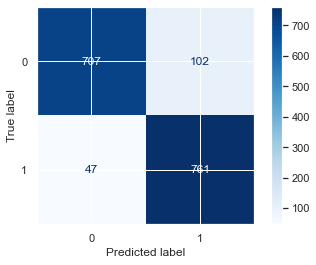

In [13]:
Forest_pred_test = Forest.predict(X_test)
plot_confusion_matrix(Forest, X_test, y_test, cmap=plt.cm.Blues);

In [14]:
print(classification_report(y_test,Forest_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       809
           1       0.88      0.94      0.91       808

    accuracy                           0.91      1617
   macro avg       0.91      0.91      0.91      1617
weighted avg       0.91      0.91      0.91      1617



In [15]:
prob = Forest.predict_proba(X_test)
prob[:3]

array([[0.26235362, 0.73764638],
       [0.88441799, 0.11558201],
       [0.33397884, 0.66602116]])

In [16]:
Forest_pred_test = np.where(prob[:,1] >= 0.6, 1, 0)

In [18]:
print(classification_report(y_test,Forest_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       809
           1       0.95      0.91      0.93       808

    accuracy                           0.93      1617
   macro avg       0.93      0.93      0.93      1617
weighted avg       0.93      0.93      0.93      1617



In [20]:
Final_pred_test = Forest.predict(test_df)
Final_prob = Forest.predict_proba(test_df)
Final_pred_test = np.where(Final_prob[:,1] >= 0.6, 1, 0)

In [21]:
pd.DataFrame(Final_pred_test).to_csv('AHabetyan_predictions.csv')